## SMDA Final Project (02 - analysis) - Agustina Pesce

The notebook has been set to run for replication without bootstrapped CIs, which was the most time consumming process. These cells remain commented out. However, tables and estimators graphs can still be outputed.

In [30]:
#Libraries 

#Dataframes use
import pandas as pd
import numpy as np

#Object saving
import pickle

#Data visualization
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['font.sans-serif'] = "Arial"
matplotlib.rcParams['font.family'] = "sans-serif"

#Linear regression packages
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

#Track processing time in loops
from tqdm import tqdm

#Mixed effects model try
import statsmodels.formula.api as smf

Import dfs with dictionary counts

In [31]:
dem_congress_countcol = pd.read_pickle("analysis_df/dem_congress_countcol")
left_mediafb_countcol = pd.read_pickle("analysis_df/left_mediafb_countcol")
rep_congress_countcol = pd.read_pickle("analysis_df/rep_congress_countcol")
right_mediafb_countcol = pd.read_pickle("analysis_df/right_mediafb_countcol")

Further preprocessing

In [32]:
#Change outgroup and ingroup column names for modelling clarity according to the theoretical question
dem_congress_countcol = dem_congress_countcol.rename(columns={"dem_count": "ingroup_count", \
                                                              "rep_count": "outgroup_count"})

left_mediafb_countcol = left_mediafb_countcol.rename(columns={"dem_count": "ingroup_count", \
                                                              "rep_count": "outgroup_count"})

rep_congress_countcol = rep_congress_countcol.rename(columns={"dem_count": "outgroup_count", \
                                                              "rep_count": "ingroup_count"})

right_mediafb_countcol = right_mediafb_countcol.rename(columns={"dem_count": "outgroup_count", \
                                                                "rep_count": "ingroup_count"})

In [33]:
def regression_prepro(df):

    df_wdummy = df.copy()

    ## Control dummies ##

    #Dummy to check if post has media (photo, video, etc.)
    df_wdummy['has_mediaTRUE'] = df['Type'].apply(lambda x: 0 if x in ['Status', 'Link'] else 1).astype('category')

    #Dummy to check if post has a Link
    df_wdummy['has_URLTRUE'] = df['Type'].apply(lambda x: 1 if x == 'Link' else 0).astype('category')

    ## NaN values dropping ##

    #Erase rows with NaN values in 'Likes at Posting' column (to implement regression)
    print('NaN in "Likes at Posting" column:', df_wdummy['Likes at Posting'].isna().sum())
    df2_dropped_na = df_wdummy.dropna(subset=['Likes at Posting'])

    ## Mean centering ##

    #Columns to center as done in paper (this helps, for instance, with intercept interpretation)
    df2_centered = df2_dropped_na.copy()
    columns_to_center = ['ingroup_count', 'outgroup_count', \
                        'neg_count', 'pos_count', 'affect_count', 'moral_emo_count',\
                        'Likes at Posting'] #no centering of categorical variables ('has_mediaTRUE', 'has_URLTRUE')

    new_columns = ['ingroup_count_c', 'outgroup_count_c', \
                    'neg_count_c', 'pos_count_c', 'affect_count_c', 'moral_emo_count_c',\
                    'Likes at Posting_c']

    #Means calculation
    means = df2_dropped_na[columns_to_center].mean()

    #Mean centering
    df2_centered[new_columns] = df2_dropped_na[columns_to_center] - means

    ## Log transformation of Shares ##

    df2_centered["shares_log"] = np.log(df2_centered['Shares'].add(1)) 
    #1 is added to avoid log(0), also done in the code of the original paper

    return df2_centered

In [34]:
#Preprocessing of all 4 dfs
dem_congress_prepro = regression_prepro(dem_congress_countcol)
left_mediafb_prepro = regression_prepro(left_mediafb_countcol)

rep_congress_prepro = regression_prepro(rep_congress_countcol)
right_mediafb_prepro = regression_prepro(right_mediafb_countcol)

NaN in "Likes at Posting" column: 65
NaN in "Likes at Posting" column: 0
NaN in "Likes at Posting" column: 190
NaN in "Likes at Posting" column: 0


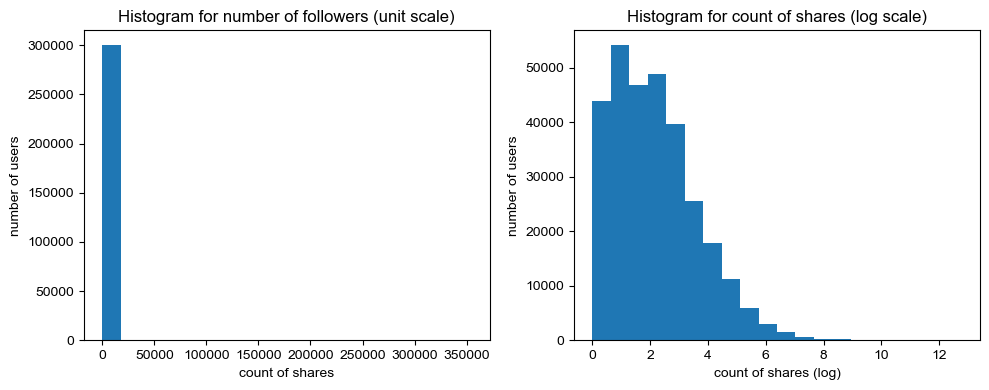

In [35]:
#Example skewness check for count and log trandformed shares (N = 300,000)

plt.figure(figsize=(10, 4))

#Histogram with the number of followers (unit scale)
plt.subplot(1, 2, 1)
plt.hist(left_mediafb_prepro["Shares"], bins= 20)
plt.title("Histogram for number of followers (unit scale)")
plt.xlabel('count of shares')
plt.ylabel('number of users')

#Histogram for number of followers (log scale)
plt.subplot(1, 2, 2)
plt.hist(left_mediafb_prepro["shares_log"], bins= 20)
plt.title("Histogram for count of shares (log scale)")
plt.xlabel('count of shares (log)')
plt.ylabel('number of users')
plt.tight_layout()

plt.show()

In [36]:
NaN_democrat_congress = set(dem_congress_countcol[dem_congress_countcol['Likes at Posting'].isna() == True]['User Name'])
len(NaN_democrat_congress)
#Rep as short for Representative

15

In [37]:
NaN_republican_congress = set(rep_congress_countcol[rep_congress_countcol['Likes at Posting'].isna() == True]['User Name'])
len(NaN_republican_congress)

36

In [38]:
np.set_printoptions(suppress=True)

variables = ['ingroup_count', 'outgroup_count', \
            'neg_count', 'pos_count', 'moral_emo_count',\
            'Likes at Posting']

descrip_data1 = pd.DataFrame()
descrip_data1["Variable"] = ['Ingroup', 'Outgroup', 'Negative Affect', 'Positive Affect', 'Moral Emotional', 
                            'Likes at Posting']
descrip_data1["M"] = np.around(left_mediafb_prepro[variables].mean().values, 2)
descrip_data1["SD"] = np.around(left_mediafb_prepro[variables].std().values, 2)

descrip_data2 = pd.DataFrame()
descrip_data2["Variable"] = ['Ingroup', 'Outgroup', 'Negative Affect', 'Positive Affect', 'Moral Emotional', 
                            'Likes at Posting']
descrip_data2["M"] = np.around(right_mediafb_prepro[variables].mean().values, 2)
descrip_data2["SD"] = np.around(right_mediafb_prepro[variables].std().values, 2)

descrip_data3 = pd.DataFrame()
descrip_data3["Variable"] = ['Ingroup', 'Outgroup', 'Negative Affect', 'Positive Affect', 'Moral Emotional', 
                            'Likes at Posting']
descrip_data3["M"] = np.around(dem_congress_prepro[variables].mean().values, 2)
descrip_data3["SD"] = np.around(dem_congress_prepro[variables].std().values, 2)

descrip_data4 = pd.DataFrame()
descrip_data4["Variable"] = ['Ingroup', 'Outgroup', 'Negative Affect', 'Positive Affect', 'Moral Emotional', 
                            'Likes at Posting']
descrip_data4["M"] = np.around(rep_congress_prepro[variables].mean().values, 2)
descrip_data4["SD"] = np.around(rep_congress_prepro[variables].std().values, 2)

with pd.ExcelWriter("descriptive_stats.xlsx") as writer:
        descrip_data1.to_excel(writer, sheet_name="left_media")
        descrip_data2.to_excel(writer, sheet_name="right_media")
        descrip_data3.to_excel(writer, sheet_name="dem_congress")
        descrip_data4.to_excel(writer, sheet_name="rep_congress")


Model fit

In [39]:
#Function to get bootstraped bounds for regression coefficients
def bootstrap_regr(df, sample_n, repetitions=10000, alpha=0.05):
    coefs = []
    intercepts = []
    
    for i in tqdm(range(repetitions), desc="Bootstrap Progress"):
        # Sample
        sampled_df = df.sample(n = sample_n, replace=True)

        # Regression
        X_columns = ['ingroup_count_c', 'outgroup_count_c', \
                    'neg_count_c', 'pos_count_c', 'moral_emo_count_c',\
                    'has_mediaTRUE', 'has_URLTRUE', 'Likes at Posting_c']
        y_column = 'shares_log'

        # Sklearn used since its faster than statsmodels
        regression_sampled = LinearRegression()
        
        regression_sampled.fit(X=sampled_df[X_columns], 
                               y=sampled_df[y_column])
        
        # Append coefficients
        coefs.append(regression_sampled.coef_)
        intercepts.append(regression_sampled.intercept_)

    #Calculation of percentile for inserted alpha
    intercept_lower_bound = np.exp(np.percentile(intercepts, 100 * alpha / 2))
    intercept_upper_bound = np.exp(np.percentile(intercepts, 100 * (1 - alpha / 2)))

    # Calculate confidence intervals for each coefficient
    num_coefficients = len(X_columns)
    coef_lower_bounds = []
    coef_upper_bounds = []

    for j in range(num_coefficients):
        #list of coeficients for a variable
        coef_samples = [sample[j] for sample in coefs]

        #Bounds calculation
        lower_bound = np.exp(np.percentile(coef_samples, 100 * alpha / 2))
        upper_bound = np.exp(np.percentile(coef_samples, 100 * (1 - alpha / 2)))

        #Append bounds (exponentiate as in paper)
        coef_lower_bounds.append(round(lower_bound,2))
        coef_upper_bounds.append(round(upper_bound,2))

    #Consolidation of bounds in one list of lists
    coef_bounds_list = []
    for lower, upper in zip(coef_lower_bounds, coef_upper_bounds):
        coef_bounds_list.append([lower, upper])
    
    all_bounds = [[round(intercept_lower_bound,2), round(intercept_upper_bound,2)]] + coef_bounds_list

    return all_bounds

In [40]:
def regression_fit_output(prepro_df, bootsCI = True, print_summ_sm = False):
    
    #Variables matrix
    var_control = prepro_df[['ingroup_count_c', 'outgroup_count_c', \
                        'neg_count_c', 'pos_count_c', 'moral_emo_count_c',\
                        'has_mediaTRUE', 'has_URLTRUE', 'Likes at Posting_c']]

    #Output variable
    shares_log = prepro_df['shares_log']

    #Get traditional regression statistis with statsmodels package
    var_control_int = sm.add_constant(var_control)
    reg_model_sm = sm.OLS(shares_log, var_control_int)
    reg_model_sm_fit = reg_model_sm.fit()

    if print_summ_sm == True:
        print(reg_model_sm_fit.summary())

    #Determine output in case "bootsCI" is set to False
    bootsCI_bounds = None

    if bootsCI == True:
        #Sample value is reduced to 150k (around half of the total sample) to reduce processing time,
        #therefore this is not the most accurate implementation of bootstraping 
        bootsCI_bounds = bootstrap_regr(prepro_df, sample_n = 150000)

    return reg_model_sm_fit, bootsCI_bounds

In [41]:
#dem_congress_fit, dem_congress_bounds = regression_fit_output(dem_congress_prepro, bootsCI = True)

In [42]:
#left_mediafb_fit, left_mediafb_bounds = regression_fit_output(left_mediafb_prepro, bootsCI = True)

In [43]:
#rep_congress_fit, rep_congress_bounds = regression_fit_output(rep_congress_prepro, bootsCI = True)

In [44]:
#right_mediafb_fit, right_mediafb_bounds = regression_fit_output(right_mediafb_prepro, bootsCI = True)

In [45]:
#Fast check without bootstraping
dem_congress_fit2, _ = regression_fit_output(dem_congress_prepro, bootsCI = False)
left_mediafb_fit2, _ = regression_fit_output(left_mediafb_prepro, bootsCI = False)
rep_congress_fit2, _ = regression_fit_output(rep_congress_prepro, bootsCI = False)
right_mediafb_fit2, _ = regression_fit_output(right_mediafb_prepro, bootsCI = False)

Tables export

In [46]:
def tidy_tables(fit_object, dataframe, filename, bootsCI_object = None):
    table1 = fit_object.summary2().tables[1]
    table2 = fit_object.summary2().tables[0]

    # VIF #
    #Independent variables set
    X = dataframe[['ingroup_count_c', 'outgroup_count_c', \
                    'neg_count_c', 'pos_count_c', 'moral_emo_count_c',\
                    'has_mediaTRUE', 'has_URLTRUE', 'Likes at Posting_c']]
    
    #VIF dataframe
    vif_data = pd.DataFrame()
    vif_data["Variable"] = ['Ingroup', 'Outgroup', 'NegativeAffect', 'PositiveAffect', 'MoralEmotional', 
                            'has_mediaTRUE', 'has_URLTRUE', 'Likes at Posting']
    
    # alculating VIF for each feature
    vif_data["VIF"] = [variance_inflation_factor(X.values, i)
                       for i in range(len(X.columns))]

    # General stats #
    N = int(table2.iloc[3,1])
    AIC = round(float(table2.iloc[1,3]), 2)
    BIC = round(float(table2.iloc[2,3]), 2)
    R2 = round(float(table2.iloc[6,1]), 2)

    general_stats = {'Model info': [N, AIC, BIC, R2]}
    index_labels=['N','AIC','BIC','R-squared']
    general_stats_table = pd.DataFrame(general_stats,index=index_labels)

    # Coefficients table #
    #Name change for tables
    output_table = table1.rename(columns={"Std.Err.": "SE_log_scale", \
                                    "P>|t|": "p-value"}, 
                                index={'const': '(Intercept)',
                                'ingroup_count_c': 'Ingroup',
                                'outgroup_count_c': 'Outgroup',
                                'neg_count_c': 'Negative Affect',
                                'pos_count_c': 'Positive Affect',
                                'moral_emo_count_c': 'Moral Emotional',
                                'Likes at Posting_c': 'Likes at Posting'})
    # Apply to multiple columns
    output_table[["Coef.","[0.025", "0.975]"]] = output_table[["Coef.","[0.025", "0.975]"]].apply(np.exp)

    #Rounding
    output_table[["Coef.", "t", "[0.025", "0.975]"]] = output_table[["Coef.", "t", "[0.025", "0.975]"]].round(2)
    output_table[["SE_log_scale", "p-value"]] = output_table[["SE_log_scale", "p-value"]].round(3)

    #Avoid "0.0" in p-value
    output_table["p-value"] = output_table["p-value"].apply(lambda x: "<0.001" if x == 0.0 else x)

    #Build CI 95% column and drop former ones, reorder
    output_table["CI 95%"] = output_table.apply(lambda x: [x['[0.025'], x['0.975]']], axis =1)
    output_table = output_table.drop(columns=["[0.025", "0.975]"])
    output_table = output_table[["Coef.", "CI 95%", "SE_log_scale", "t", "p-value"]]
    index_order = ['(Intercept)', 'Ingroup', 'Outgroup', 'Negative Affect', 'Positive Affect', 
                   'Moral Emotional', 'has_mediaTRUE', 'has_URLTRUE', 'Likes at Posting']
    output_table = output_table.reindex(index_order)

    if bootsCI_object != None:
        output_table["B. CI 95%"] = bootsCI_object

    # Descriptive stats # 
    descrip_col = ['ingroup_count', 'outgroup_count', \
                    'neg_count', 'pos_count', 'moral_emo_count',\
                    'Likes at Posting', 'Shares']
                    #, 'affect_count', 'has_mediaTRUE', 'has_URLTRUE',

    means = np.around(dataframe[descrip_col].mean().values, 2)
    sd = np.around(dataframe[descrip_col].std().values, 2)

    descrip_data = {'M': means,
                    'SD': sd}

    # Define index names (optional)
    index_names = ['Ingroup', 'Outgroup', \
                    'NegativeAffect', 'PositiveAffect', 'MoralEmotional',\
                    'Likes at Posting', 'Shares']

    # Create the DataFrame
    descrip_frame = pd.DataFrame(descrip_data, index=index_names)
    
    with pd.ExcelWriter(filename) as writer:
        output_table.to_excel(writer, sheet_name="output_table")
        general_stats_table.to_excel(writer, sheet_name="general_stats_table")
        vif_data.to_excel(writer, sheet_name="vif_data")
        descrip_frame.to_excel(writer, sheet_name="descrip_frame")
        table1.to_excel(writer, sheet_name="table1")
        table2.to_excel(writer, sheet_name="table2")

    return output_table

In [47]:
#dem_congress_coef = tidy_tables(dem_congress_fit, dem_congress_prepro, "dem_congress_fit.xlsx", dem_congress_bounds)
#left_mediafb_coef = tidy_tables(left_mediafb_fit, left_mediafb_prepro, "left_mediafb_fit.xlsx", left_mediafb_bounds)

#rep_congress_coef = tidy_tables(rep_congress_fit, rep_congress_prepro, "rep_congress_fit.xlsx", rep_congress_bounds)
#right_mediafb_coef = tidy_tables(right_mediafb_fit, right_mediafb_prepro, "right_mediafb_fit.xlsx", right_mediafb_bounds)

In [48]:
#Fast check without bootstraping
dem_congress_coef2 = tidy_tables(dem_congress_fit2, dem_congress_prepro, "dem_congress_fit2.xlsx")
left_mediafb_coef2 = tidy_tables(left_mediafb_fit2, left_mediafb_prepro, "left_mediafb_fit2.xlsx")

rep_congress_coef2 = tidy_tables(rep_congress_fit2, rep_congress_prepro, "rep_congress_fit2.xlsx")
right_mediafb_coef2 = tidy_tables(right_mediafb_fit2, right_mediafb_prepro, "right_mediafb_fit2.xlsx")

In [49]:
def coef_graph(df1, df2, title, file, label1, label2):
    'df1 should be democrat/left (blue)'
    'df2 should be republican/right (red)'
    'lables are correspondent to df1 and df2'

    # Create a figure and axis
    fig, ax = plt.subplots(figsize=(4, 3))

    # Filter out the '(Intercept)' variable and controls
    coef_interest = ['Moral Emotional', 'Positive Affect', 'Negative Affect', 'Ingroup', 'Outgroup']
    
    coef_df1 = df1.loc[coef_interest]
    coef_df2 = df2.loc[coef_interest]

    # Extract variable names and coefficients
    variables = coef_df1.index
    coefficients1 = coef_df1['Coef.']
    coefficients2 = coef_df2['Coef.']

    # Plot coefficients as dots
    ax.plot(coefficients1, range(len(variables)), 'o', markersize=5, label=label1, color = '#4A658A', alpha=0.9) #alpha for overlapping dots
    ax.plot(coefficients2, range(len(variables)), 'o', markersize=5, label=label2, color = '#DB453B', alpha=0.9)
    
    # Add a vertical line at 1 (no effect)
    ax.axvline(x=1, color='grey', linestyle='--')

    # Set axis ticks and labels to variable names
    x = [0.9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6]
    #x = list(np.arange(0.9, 1.8, 0.1)) #rounding problem
    ax.set_xticks(x)  # Set the tick positions
    ax.set_xticklabels(x, fontsize=8)
    ax.set_xlim(0.87, 1.67)
    
    ax.set_yticks(range(len(variables)), size = 8)
    ax.set_yticklabels(variables, size = 8)

    # Set labels and title
    ax.set_xlabel('Change in odds of share', size = 9)
    ax.set_title(title, size = 9, pad = 13, linespacing = 1.5)

    # Add legend
    ax.legend(loc='lower left', bbox_to_anchor=(1, 0.83), fontsize=8)

    # Save and show the plot
    plt.savefig(fname =  "graphs/" + file + '.png', bbox_inches='tight')
    plt.show()

In [50]:
#coef_graph(dem_congress_coef, rep_congress_coef, file = 'Congress_coef_graph',
#           label1='Democrat', label2='Republican', title = 'Democrat and Republican Congress \nmembers posts')

In [51]:
#coef_graph(left_mediafb_coef, right_mediafb_coef, file = 'Media_coef_graph',
#           label1='Left', label2='Right', title = 'Left and Right media posts')

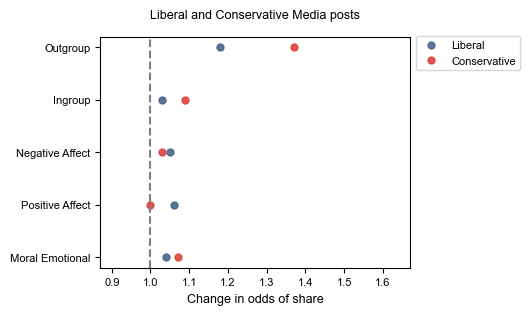

In [60]:
#Fast check without bootstraping (coefficients graphs are built on punctual estimators)
coef_graph(left_mediafb_coef2, right_mediafb_coef2, file = 'Media_coef_graph2',
           label1='Liberal', label2='Conservative', title = 'Liberal and Conservative Media posts')

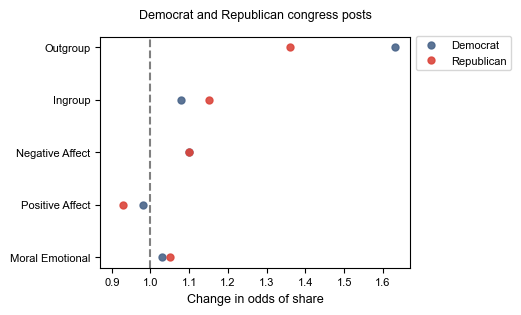

In [58]:
#Fast check without bootstraping (coefficients graphs are built on punctual estimators)
coef_graph(dem_congress_coef2, rep_congress_coef2, file = 'Congress_coef_graph2',
           label1='Democrat', label2='Republican', title = 'Democrat and Republican congress posts')

VADER polarity scores

In [56]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

In [57]:
sid = SentimentIntensityAnalyzer()
pols = sid.polarity_scores(dem_congress_prepro['Message'][4])
print(dem_congress_prepro['Message'][4])
print(pols)

Republicans’ top priority is derailing the economic success Democrats created for Americans the last few years. First they tried default, now they’re talking shutdown. Rating agencies have taken note. Republicans see your economic pain as their political gain.
{'neg': 0.07, 'neu': 0.699, 'pos': 0.231, 'compound': 0.765}
